<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/hw3_convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

# 1 Setup

In [0]:
import numpy as np
import os
import cv2
import torch
from torch import nn,optim
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader,Dataset,TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2 准备数据

In [0]:
ROOT='./food-11'
train_path=os.path.join(ROOT,'training')
valid_path=os.path.join(ROOT,'validation')
test_path=os.path.join(ROOT,'testing')
def readfile(filepath,labeled=True):
  file_list=os.listdir(filepath)
  L=len(file_list)
  data=np.zeros((L,128,128,3),dtype=np.uint8)
  label=np.zeros((L,),dtype=np.uint8)
  for i,name in enumerate(file_list):
    filename=os.path.join(filepath,name)
    img=cv2.imread(filename)
    data[i]=cv2.resize(img,(128,128))
    if labeled:
      label[i]=int(name.split('_')[0])
  if labeled:
    return data,label
  else:
    return data

In [0]:
train_data,train_label=readfile(train_path)
valid_data,valid_label=readfile(valid_path)


In [0]:
test_data=readfile(test_path,labeled=False)

In [8]:
print('train_data.shape:{},train_label.shape:{}'.format(train_data.shape,train_label.shape))

train_data.shape:(9866, 128, 128, 3),train_label.shape:(9866,)


In [0]:
train_data=torch.from_numpy(train_data)
train_label=torch.from_numpy(train_label)
valid_data=torch.from_numpy(valid_data)
valid_label=torch.from_numpy(valid_label)
train_dataset=TensorDataset(train_data,train_label)
valid_dataset=TensorDataset(valid_data,valid_label)

In [10]:
len(train_dataset),len(valid_dataset)

(9866, 3430)

In [0]:
batch_size=256
train_iter=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_iter=DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)

In [0]:
for X,Y in train_iter:
  print(X[1])
  break

# 3 数据感知

In [0]:
def show(data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  fig=plt.figure(figsize=(7,7))
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    b,g,r=cv2.split(img[i].numpy())
    ax.imshow(cv2.merge([r,g,b]))
    ax.set_title(str(label[i].item()))

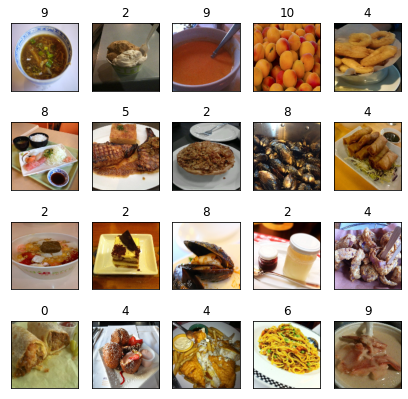

In [67]:
show(train_iter,20)

# 4 模型

In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward(self,x):
    return x.reshape(x.shape[0],-1)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.cnn=nn.Sequential(
        nn.Conv2d(3,16,3,1,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16,32,3,1,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,3,1,1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,256,3,1,1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.fc=nn.Sequential(
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,11)
    )
    self.flatten=FlattenLayer()
  def forward(self,x):
    x=x.permute(0,3,1,2)
    x=self.cnn(x)
    x=self.flatten(x)
    x=self.fc(x)
    return x

# 5 训练

In [0]:
def evaluate_acc(model,data_iter):
  model.eval()
  acc,n=0.0,0
  with torch.no_grad():
    for X,Y in data_iter:
      X=X/255.
      acc+=(model(X.to(device)).argmax(dim=1)==Y.to(device)).sum().item()
      n+=Y.shape[0]
    return acc/n

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr)
  valid_min_loss=np.inf
  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X/255.
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y.long())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      # print('train loss:',loss.item())
    model.eval()
    with torch.no_grad():
      for X,Y in valid_iter:
        X=X/255.
        X=X.to(device)
        Y=Y.to(device)
        y_pred=model(X)
        loss=criterion(y_pred,Y.long())
        valid_loss+=loss.item()*X.shape[0]
        # print('valid loss',loss.item())
    train_loss=train_loss/len(train_dataset)
    valid_loss=valid_loss/len(valid_dataset)

    train_acc=evaluate_acc(model,train_iter)
    valid_acc=evaluate_acc(model,valid_iter)
    # train_acc,valid_acc=0,0

    if valid_loss<valid_min_loss:
      print('validation decreased {}-->{}.saving model...'.\
            format(valid_min_loss,valid_loss))
      torch.save(model.state_dict(),'model.pt')
    print('epoch:{},train loss:{},valid loss:{},train acc:{},valid acc:{}'.\
          format(epoch+1,train_loss,valid_loss,train_acc,valid_acc))

In [22]:
model=Net()
num_epochs,lr=5,0.001
train(model,num_epochs,lr,train_iter,valid_iter)

validation decreased inf-->3.5444847084690463.saving model...
epoch:1,train loss:2.2369251504718664,valid loss:3.5444847084690463,train acc:0.15193594161767687,valid acc:0.1457725947521866
validation decreased inf-->1.8880055813330603.saving model...
epoch:2,train loss:1.8794509663002839,valid loss:1.8880055813330603,train acc:0.35830123657003854,valid acc:0.34752186588921286
validation decreased inf-->1.7437617546615378.saving model...
epoch:3,train loss:1.7447437053999793,valid loss:1.7437617546615378,train acc:0.408270829110075,valid acc:0.3825072886297376
validation decreased inf-->1.7211917840357076.saving model...
epoch:4,train loss:1.6106767557514576,valid loss:1.7211917840357076,train acc:0.4223596188931685,valid acc:0.39387755102040817
validation decreased inf-->1.712821272441319.saving model...
epoch:5,train loss:1.5081586607227986,valid loss:1.712821272441319,train acc:0.43523211027772146,valid acc:0.42303206997084547


# 6 测试

In [0]:
def check(model,data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img=show_some[0]
  img=img/255.
  pred=model(img.to(device)).argmax(dim=1)
  fig=plt.figure(figsize=(7,7))
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    b,g,r=cv2.split(img[i].numpy())
    ax.imshow(cv2.merge([r,g,b]))
    ax.set_title(str(pred[i].item()))

In [0]:
test_data=torch.from_numpy(test_data)
test_dataset=TensorDataset(test_data)
test_iter=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=4)

In [18]:
for X in test_iter:
  print(X[0].shape)

torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([256, 128, 128, 3])
torch.Size([19, 128, 128, 3])


In [26]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

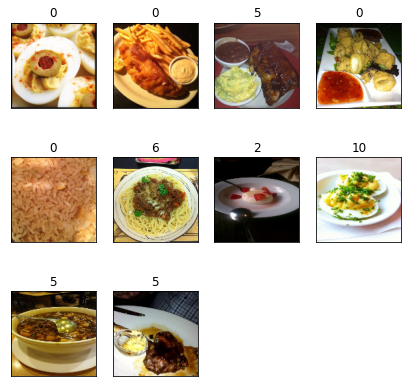

In [25]:
check(model,test_iter,10)

# 7 将train_dataset和valid_dataset一起用于训练

> 增加数据量，再次训练，提高模型效果

In [27]:
train_data.shape,valid_data.shape

(torch.Size([9866, 128, 128, 3]), torch.Size([3430, 128, 128, 3]))

In [28]:
dataset=torch.cat((train_data,valid_data),0)
dataset.shape

torch.Size([13296, 128, 128, 3])

In [0]:
label=torch.cat((train_label,valid_label))

In [0]:
data=TensorDataset(dataset,label)

In [0]:
data_iter=DataLoader(data,batch_size=batch_size,shuffle=True,num_workers=4)

In [0]:
for X,Y in data_iter:
  print(X.shape,Y.shape)
  break

In [0]:
def s_train(model,num_epochs,lr,train_iter):
  model=model.to(device)
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr)
  for epoch in range(num_epochs):
    train_loss=0.0
    model.train()
    for X,Y in train_iter:
      X=X/255.
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y.long())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      # print('train loss:',loss.item())
    train_loss=train_loss/len(train_dataset)
    train_acc=evaluate_acc(model,train_iter)
    print('epoch:{},train loss:{},train acc:{}'.\
          format(epoch+1,train_loss,train_acc))

In [35]:
s_train(model,num_epochs,lr,train_iter)

epoch:1,train loss:1.4216619928879257,train acc:0.4976687614027975
epoch:2,train loss:1.2655491781553727,train acc:0.55969997972836
epoch:3,train loss:1.1576460458046762,train acc:0.5589904723292114
epoch:4,train loss:1.064583212493666,train acc:0.5681127103182647
epoch:5,train loss:0.9697432587481696,train acc:0.6909588485708493
